## Residual Network 

**Summary:** 

The purpose of this notebook is to  experiment with the ResNet architecture for specifically key-word spotting. The model applied is called the `res8-narrow`. This is model comes from a reduced base model, `resnet15`, where the authors proposed to reduce the number of residual blocks from 6 to 3 to allow a smaller footprint model that has a reduced network depth. Additionally, the authors compacted model includes a 4x3 average-pooling layer after the first convolution layer to reduce the size of the time and frequency dimensions by a factor of four and three. Lastly they decided to omit dilated convolutions sinces the average-pooling layer had reduced the input dimension.
Both models come from "Deep Residual Learning for Small-Footprint Keyword Spotting" by Raphael Tang and Jimmy Lin [1].

In [1]:
pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Dependencies

In [2]:
import os
from tqdm import tqdm
import sys
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
import pandas as pd
import numpy as np
from scipy.io import wavfile

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import warnings
from scipy.io.wavfile import WavFileWarning
from sklearn.metrics import accuracy_score
import visualkeras
from visualkeras import SpacingDummyLayer

warnings.simplefilter("ignore", WavFileWarning)
# conversion causes lots of pink warning errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # '0' = all logs, '1' = info, '2' = warnings, '3' = errors only
tf.get_logger().setLevel('ERROR')

# dependencies for compute_multiclass_metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_fscore_support, roc_auc_score

from sklearn.preprocessing import label_binarize
from sklearn.metrics import balanced_accuracy_score

2024-12-17 10:15:24.113010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 10:15:24.859149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 10:15:24.861054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 10:15:25.049869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 10:15:25.361739: I tensorflow/core/platform/cpu_feature_guar

## Path Variables

In [3]:
random_state = 42
n_mel = 40

In [4]:
data_path = f'/home/bukowskin/CSC_7901_ML_Capstone/data/data_split_random_state_{random_state}/number_mel_filters_{n_mel}'

mfe_data_path = f'{data_path}/mfe_data_split'
mfcc_data_path = f'{data_path}/mfcc_data_split'

save_model_path = f'/home/bukowskin/CSC_7901_ML_Capstone/models'

## Function

In [5]:
def accuarcy_after_quan(model_path, test_data, y_true, feat_type, trial):
    """
    Function used to check model accuracy after TensorFlow Lite conversion with quanitization applied. Stated
    there can be a possible accuracy change. 
        Args:
            model_path(str): path to saved model
            test_data (np.array): testing data
            y_true (np.array): true labels for testing data
        Returns:
            None
    """

    # load TensorFlow Lite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()  

    # get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # initialize an empty list for storing predictions
    y_pred_probs = []

    # setting batch size for prediction 
    batch_size = 64
    num_batches = len(test_data) // batch_size

    # process sample by sample 
    for i in range(test_data.shape[0]):
        sample_data = test_data[i:i+1]  # select one sample, shape is (1, height, width, channels)

        # making sure data is in the correct format (float32)
        sample_data = sample_data.astype(np.float32)

        # setting input tensor for the current sample
        interpreter.set_tensor(input_details[0]['index'], sample_data)

        # running inference
        interpreter.invoke()

        # getting output tensor (the predictions)
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # appending predictions to the list
        y_pred_probs.append(output_data)

    # combining predictions from all samples into a single NumPy array
    y_pred_probs = np.vstack(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1) 

    # accuracy
    accuracy = accuracy_score(y_true, y_pred)
    if trial:
        return accuracy
    
    if feat_type == 'mfe':
        print(f'MFE Feature Accuracy: {accuracy * 100:.2f}%')
    elif feat_type == 'mfcc':
        print(f'MFCC Feature Accuracy: {accuracy * 100:.2f}%')

In [6]:
def compute_multiclass_metrics(y_true, y_pred_probs, label_mapping):
    """
    Function to compute and plot One-vs-Rest ROC curves and calculate weighted averages for metrics.
    
    Args:
        y_true: Array of true labels (integer-encoded).
        y_pred_probs: Array of predicted probabilities for each class.
        label_mapping: Dictionary mapping class indices to human-readable names.
    Returns:
        None
    """
    n_classes = len(label_mapping) 
    y_true_bin = label_binarize(y_true, classes=list(label_mapping.keys())) 

    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting ROC
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i], lw=2,
            label=f'Class {label_mapping[i]} (AUC = {roc_auc[i]:.2f})'
        )
    
    # plotting random guess line 
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

    # weighted avg metrics
    y_pred = np.argmax(y_pred_probs, axis=1)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Weighted Average Precision: {precision:.2f}")
    print(f"Weighted Average Recall: {recall:.2f}")
    print(f"Weighted Average F1-Score: {f1_score:.2f}")

    # micro-avg AUC
    micro_auc = roc_auc_score(y_true_bin, y_pred_probs, average='micro')
    print(f"Micro-Average AUC: {micro_auc:.2f}")

    # report
    class_report = classification_report(
        y_true, y_pred, target_names=[f"Class {label_mapping[i]}" for i in range(n_classes)]
    )
    print("\nClassification Report:\n", class_report)


## Data

### Load MFE Data

In [7]:
with open(f'{mfe_data_path}/train_data.pkl', 'rb') as f:
    mfe_train = pickle.load(f)
    
with open(f'{mfe_data_path}/test_data.pkl', 'rb') as f:
    mfe_test = pickle.load(f)

In [8]:
# train 
train_mfe_feat = mfe_train['features']
y_train = mfe_train['labels']

# test 
test_mfe_feat = mfe_test['features']
y_test = mfe_test['labels']

# height and width
mfe_height = mfe_train['mfe_height']
mfe_width = mfe_train['mfe_width']

### Load MFCC  Data

In [9]:
with open(f'{mfcc_data_path}/train_data.pkl', 'rb') as f:
    mfcc_train = pickle.load(f)
    
with open(f'{mfcc_data_path}/test_data.pkl', 'rb') as f:
    mfcc_test = pickle.load(f)

In [10]:
# train 
train_mfcc_feat = mfcc_train['features']

# test 
test_mfcc_feat = mfcc_test['features']

# height and width
mfcc_height = mfcc_train['mfe_height']
mfcc_width = mfcc_train['mfe_width']

### Prepare Data

Taking the computed height and width and reshaping features for model input

### MFE Features

In [11]:
# train
train_mfe_feat = np.array(train_mfe_feat)
train_mfe_feat= train_mfe_feat.reshape(-1, mfe_height, mfe_width, 1)
print(f'Training MFE Features Shape: {train_mfe_feat.shape}')

# test
test_mfe_feat = np.array(test_mfe_feat)
test_mfe_feat= test_mfe_feat.reshape(-1, mfe_height, mfe_width, 1)
print(f'Testing MFE Features Shape: {test_mfe_feat.shape}')

Training MFE Features Shape: (1055, 40, 50, 1)
Testing MFE Features Shape: (264, 40, 50, 1)


### MFCC Features

In [12]:
# train
train_mfcc_feat = np.array(train_mfcc_feat)
train_mfcc_feat= train_mfcc_feat.reshape(-1,mfcc_height, mfcc_width, 1)
print(f'Training MFCC Features Shape: {train_mfcc_feat.shape}')

# test
test_mfcc_feat = np.array(test_mfcc_feat)
test_mfcc_feat= test_mfcc_feat.reshape(-1, mfcc_height, mfcc_width, 1)
print(f'MFCC Features Shape: {test_mfcc_feat.shape}')

Training MFCC Features Shape: (1055, 13, 50, 1)
MFCC Features Shape: (264, 13, 50, 1)


### Labels

In [13]:
# train
# encoding labels to numerical representations
train_label_encoder = LabelEncoder()
y_train = train_label_encoder.fit_transform(y_train)
label_mapping = dict(zip(range(len(train_label_encoder.classes_)),train_label_encoder.classes_,))


# test
# encoding labels to numerical representations
test_label_encoder = LabelEncoder()
y_test = test_label_encoder.fit_transform(y_test)
label_mapping = dict(zip(range(len(test_label_encoder.classes_)),test_label_encoder.classes_))


print(f'Label mapping: {label_mapping}')

Label mapping: {0: 'blue', 1: 'green', 2: 'one', 3: 'red', 4: 'three', 5: 'two'}


## ResNet8-Narrow

In [14]:
def residual_block(x, filters):
    """
    Function for implementing standard ResNet architecture, residual block. This includes a 2 3x3 convolutional with 
    batch normalization and ReLu activation
    Additionally, unlike the resnet15 (which the model deviates from), this one doesn't include a dimension adjustment.
        Args:
            filters(int): number of filters used for Conv2D 
        Returns:
            tensor: processed data after Con2d, Relu and BatchNorm 
    """

    # save input for skip connection
    shortcut = x

    # 1st convolution layer
    y = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    y = layers.ReLU()(y)
    y = layers.BatchNormalization()(y)
    

    # 2nd convolution layer
    y = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(y)
    y = layers.ReLU()(y)
    y = layers.BatchNormalization()(y)

    # adding skip connection
    y = layers.add([shortcut, y])

    return y
    

def build_resnet_8(input_shape, num_classes,feat_maps):
    """
    Function builds the ResNet model as described in the paper.
    """
    inputs = layers.Input(shape=input_shape)

    # initial convolution layer
    x = layers.Conv2D(feat_maps, (3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 4x3 average pooling 
    x = layers.AveragePooling2D(pool_size=(4, 3))(x)

    # 3 residual blocks 
    for _ in range(3):
        x = residual_block(x, feat_maps)

    # global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # fully connected softmax layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # initialize model
    model = models.Model(inputs, outputs)

    return model

### Train Model

#### MFE

In [17]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.1,
    momentum=0.9, 
    weight_decay=1e-5
)

# learning rate scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=3,
    verbose=1
)

input_shape_mfe = (mfe_height, mfe_width, 1) # (height, width, channels)

# build the model
model_mfe = build_resnet_8(input_shape_mfe, num_classes=6, feat_maps=32) # red, green, blue, one, two, three

# model summary
model_mfe.summary()

# Compile the model
model_mfe.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

2024-12-15 02:11:20.248778: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-15 02:11:20.248838: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dh-node13
2024-12-15 02:11:20.248851: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dh-node13
2024-12-15 02:11:20.248943: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: INVALID_ARGUMENT: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2024-12-15 02:11:20.248976: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 555.42.2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 50, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 50, 32)           288       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 40, 50, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 40, 50, 32)           0         ['batch_normalization[0][0

In [18]:
# train
history = model_mfe.fit(
    train_mfe_feat,    
    y_train,
    epochs = 26,
    batch_size = 64,
    callbacks = [lr_scheduler]
)

Epoch 1/26
17/17 [==============================] - 2s 26ms/step - loss: 2.0000 - accuracy: 0.2114 - lr: 0.1000
Epoch 2/26
17/17 [==============================] - 0s 25ms/step - loss: 1.7993 - accuracy: 0.2303 - lr: 0.1000
Epoch 3/26
17/17 [==============================] - 0s 25ms/step - loss: 1.6856 - accuracy: 0.2995 - lr: 0.1000
Epoch 4/26
17/17 [==============================] - 0s 24ms/step - loss: 1.5904 - accuracy: 0.3460 - lr: 0.1000
Epoch 5/26
17/17 [==============================] - 0s 24ms/step - loss: 1.5171 - accuracy: 0.3791 - lr: 0.1000
Epoch 6/26
17/17 [==============================] - 0s 22ms/step - loss: 1.4301 - accuracy: 0.4085 - lr: 0.1000
Epoch 7/26
17/17 [==============================] - 0s 22ms/step - loss: 1.3030 - accuracy: 0.4739 - lr: 0.1000
Epoch 8/26
17/17 [==============================] - 0s 23ms/step - loss: 1.3007 - accuracy: 0.4967 - lr: 0.1000
Epoch 9/26
17/17 [==============================] - 0s 23ms/step - loss: 1.1593 - accuracy: 0.5318 - lr:

### MFCC 

In [15]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.1, 
    momentum=0.9, 
    weight_decay=1e-5
)

# learning rate scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=3,
    verbose=1
)

input_shape_mfcc = (mfcc_height, mfcc_width, 1) # (height, width, channels)

# build the model
model_mfcc = build_resnet_8(input_shape_mfcc, num_classes=6, feat_maps=32) # red, green, blue, one, two, three

# model summary
model_mfcc.summary()

# compile the model
model_mfcc.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


2024-12-17 10:16:03.863496: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-17 10:16:03.863569: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dh-node19
2024-12-17 10:16:03.863586: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dh-node19
2024-12-17 10:16:03.863704: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: INVALID_ARGUMENT: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2024-12-17 10:16:03.863746: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 555.42.2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 50, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 50, 32)           288       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 13, 50, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 13, 50, 32)           0         ['batch_normalization[0][0

In [16]:
# train
history = model_mfcc.fit(
    train_mfcc_feat,    
    y_train,
    epochs = 26,
    batch_size = 64,
    callbacks = [lr_scheduler]
)

Epoch 1/26
17/17 [==============================] - 2s 13ms/step - loss: 1.4853 - accuracy: 0.3867 - lr: 0.1000
Epoch 2/26
17/17 [==============================] - 0s 12ms/step - loss: 1.0902 - accuracy: 0.5649 - lr: 0.1000
Epoch 3/26
17/17 [==============================] - 0s 12ms/step - loss: 0.9252 - accuracy: 0.6332 - lr: 0.1000
Epoch 4/26
17/17 [==============================] - 0s 12ms/step - loss: 0.7303 - accuracy: 0.7261 - lr: 0.1000
Epoch 5/26
17/17 [==============================] - 0s 12ms/step - loss: 0.6184 - accuracy: 0.7649 - lr: 0.1000
Epoch 6/26
17/17 [==============================] - 0s 12ms/step - loss: 0.5644 - accuracy: 0.7924 - lr: 0.1000
Epoch 7/26
17/17 [==============================] - 0s 11ms/step - loss: 0.4787 - accuracy: 0.8427 - lr: 0.1000
Epoch 8/26
17/17 [==============================] - 0s 11ms/step - loss: 0.4582 - accuracy: 0.8351 - lr: 0.1000
Epoch 9/26
17/17 [==============================] - 0s 11ms/step - loss: 0.3981 - accuracy: 0.8588 - lr:

### Analysis

ResNet outputs probabilities of how likely a a sample is of the 6 classes. The final layer is a dense (or fully connected) layer with a softmax activation. 
To get the label and compare to true labels will take the argmax (whichever class of each sample had the highest probabilty). 

In [ ]:
# MFE
y_pred_mfe_probs = model_mfe.predict(test_mfe_feat, batch_size=64)
y_pred_mfe = np.argmax(y_pred_mfe_probs, axis=1)

accur_mfe = accuracy_score(y_test, y_pred_mfe)
weighted_accur_mfe = balanced_accuracy_score(y_test, y_pred_mfe)
print(f'MFE Feature Accuracy: {accur_mfe * 100:.2f}%')
print(f'MFE Feature Weighted Accuracy: {weighted_accur_mfe * 100:.2f}%')


# MFCC
y_pred_mfcc_probs = model_mfcc.predict(test_mfcc_feat, batch_size=64)
y_pred_mfcc = np.argmax(y_pred_mfcc_probs, axis=1)

accur_mfcc = accuracy_score(y_test, y_pred_mfcc)
weighted_accur_mfcc = balanced_accuracy_score(y_test, y_pred_mfcc)
print(f'MFCC Feature Accuracy: {accur_mfcc * 100:.2f}%')
print(f'MFCC Feature Weighted Accuracy: {weighted_accur_mfcc * 100:.2f}%')


## Quantization & Save

#### MFE

In [ ]:
# converting to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_mfe)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # enabling default optimizations
tflite_model = converter.convert()

# saving model
model_path_mfe = f'{save_model_path}/resnet8_mfe_nmel_{n_mel}_rand_{random_state}_32_feat.tflite'
with open(model_path_mfe, "wb") as f:
    f.write(tflite_model)  # `tflite_model` is the quantized model from earlier steps

# obtain model size
model_size_bytes = os.path.getsize(model_path_mfe)
model_size_kb = model_size_bytes / 1024  # Convert bytes to KB
print(f"Model size: {model_size_kb:.2f} KB")

#### MFCC

In [18]:
# converting to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_mfcc)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # enabling default optimizations
tflite_model = converter.convert()

# saving model
model_path_mfcc = f'{save_model_path}/resnet8_mfcc_nmel_{n_mel}_rand_{random_state}_32_feat.tflite'
with open(model_path_mfcc, "wb") as f:
    f.write(tflite_model)  # `tflite_model` is the quantized model from earlier steps

# obtain model size
model_size_bytes = os.path.getsize(model_path_mfcc)
model_size_kb = model_size_bytes / 1024  # Convert bytes to KB
print(f"Model size: {model_size_kb:.2f} KB")

Model size: 68.05 KB


2024-12-17 10:16:22.576042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-12-17 10:16:22.576079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-12-17 10:16:22.576413: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmps68cho1r
2024-12-17 10:16:22.579662: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-12-17 10:16:22.579683: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmps68cho1r
2024-12-17 10:16:22.585722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-12-17 10:16:22.588305: I tensorflow/cc/saved_model/loader.cc:235] Restoring SavedModel bundle.
2024-12-17 10:16:22.687303: I tensorflow/cc/saved_model/loader.cc:219] Running initialization op on SavedModel bundle at path: /tmp/tmps68cho1r
2024-12

## Analysis 

See how much accuracy has changed after quantization

### Final MFE Accuracy

In [ ]:
accuarcy_after_quan(model_path_mfe, test_mfe_feat, y_test, 'mfe')

### Final MFCC Accuracy

In [ ]:
accuarcy_after_quan(model_path_mfcc, test_mfcc_feat, y_test, 'mfcc')

### MFE ROC

In [ ]:
compute_multiclass_metrics(y_test, y_pred_mfe_probs, label_mapping)

### MFCC ROC

In [ ]:
compute_multiclass_metrics(y_test, y_pred_mfcc_probs, label_mapping)

## Confusion Matrix

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_mfcc)

# displaying confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=label_mapping.values())
disp.plot(cmap='Blues')
plt.title("Random Forest: Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

## Visualize Model Archiecture

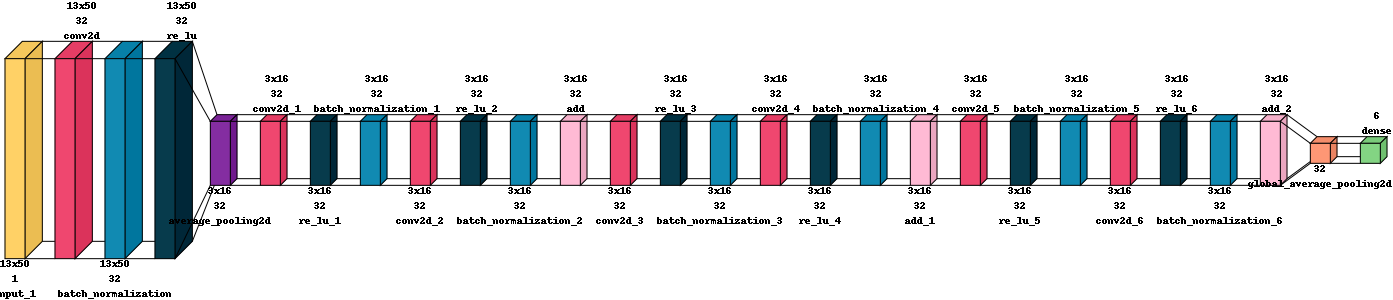

In [55]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    # Get the output shape of the layer
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

visualkeras.layered_view(
    model_mfcc,
    text_callable=text_callable, spacing=30,
    padding=5).show()

## References

[1] Tang, Raphael, and Jimmy Lin. “Deep residual learning for small-footprint keyword spotting.” 2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 21 Sept. 2018, https://doi.org/10.1109/icassp.2018.8462688. 

[2] Jongboom, Jan, et al. “Edgeimpulse/Processing-Blocks: Signal Processing Blocks.” GitHub, Edge Impulse, 3 Mar. 2022, github.com/edgeimpulse/processing-blocks. 

[3] https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc

[4] https://github.com/paulgavrikov/visualkeras/tree/master